# Predicting car prices

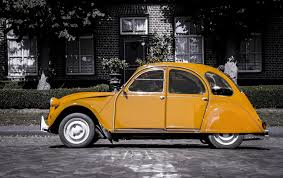

# Goals

This kernel hopes to accomplish many goals, including:
   <ul>
 <li>Learn how to scrape a website using Beautifulsoup.</li>
 <li>Combine multiple datasets into a cool new dataset which can be used to predict car prices.</li>
 <li>Create an accurate model which lets your predict car prices and helps you find the best bang for you buck car.</li>
 </ul>

# Introduction

We fellow Dutchmen really love a good bargain. Seeing a 30% off tag really gets us excited and we will tell all of our family and friends about the great cheap purchase we made. For used cars this is however difficult since we don't really know what the value of a car is. In this notebook I will combine two datasets and train a machine learning model which predicts the price of a car given specific inputs. This way it is possible to quickly go over a large list of cars and check which cars are put online for too little and are thus a great bargain. We can now finally tell all our friends and family not only about the beautiful new car we purchased, but also about how this car was a great bargain!

The Notebook is set up as following:
<ol>
 <li> Scrape a website for relevant information about cars and their prices.</li>
 <li> Combine this dataset with another freely available dataset (from RDW).</li>
     <li>Perform EDA on the combined dataset.</li>
 <li>Clean the dataset and choose a number of columns which will be used to predict car prices.</li>
 <li>Perform feature engineering to create new interesting features which will help to create a more accurate model. </li>
 <li>Split the dataset into train, test and holdout sets and test multiple machine learning models for their performance. The two metrics which are used to test the models are MAE and MAPE because of their very nice interpretability.</li>
 <li>After hyperparameter optimization of the best performing model, the model is trained on the dataset.</li>
  <li>And then finally the model is used for the goal: find a great bargain in a list of used cars which is put online. </li>
 </ol>

# 1. Importing necessary Libraries

In [1]:
# Essentials
import pandas as pd
import numpy as np
import re
from datetime import date

# Plots 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost
import catboost
import lightgbm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Misc
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV, learning_curve

# 2. Collecting and combining the datasets

I could not find a good dataset on internet so I had to scrape a dataset to find recent car prices in the Netherlands. Following are a couple of functions which together allow me to scrape a site and create a dataset containing actual car prices. I will combine this dataset with an open dataset from the RDW. These datasets will be joined using the license plate number.

#### This function scrapes the relevent info from a page

In [2]:
def get_info(link):
    # Fetch the html code from the link provided
    req = Request(link)
    html_page = urlopen(req)

    # Beautifulsoup helps to pull data out of the html file. 
    # Using Beautifulsoup I search for the first dl element, where my data is. 
    # Inside this element I search for the dt and dd elements which contain my data and which I will combine later.
    soup = BeautifulSoup(html_page, "html")
    dl = soup.find('dl', class_ = "dl-horizontal")
    info1 = dl.find_all('dt')
    info2 = dl.find_all('dd')
                
    # I put the aqcuired info in text from inside two tables. 
    # I do not want to include values including 'Zakelijk', because for these rows there is a 1:2 ratio keys to values,
    # which means the values will otherwise not match with the corresponding keys
    keys = [x.text for x in info1]
    values = [x.text for x in info2 if 'Zakelijk' not in x.text]
    
    # Use Regex to capture the correct key
    for i in range(len(keys)):
        keys[i] = re.search('(.+)\:', keys[i]).group(1)
        
    # Combine the keys and values into one dict
    info_combined = {}
    for i in range(len(keys)):
        info_combined[keys[i]] = values[i]
    
    # Use Regex to clean up the values and only capture the relevant information.
    # I included extra terms behind the info_combined term to parse the value 'null', when the string doesn't match.
    # I checked and the string will not match if it is for example an empty field.
    info_combined['Kilometerstand'] = re.search('(.+)\xa0', info_combined['Kilometerstand']+'null\xa0').group(1).replace(".","")
    info_combined['Prijs'] = re.search('€(.+),', info_combined['Prijs']).group(1).replace(".","")
    info_combined['Wegenbelasting'] = re.search('€ (.+)\xa0', info_combined['Wegenbelasting']+'€ null\xa0').group(1)
    info_combined['Vermogen'] = re.search('(.+) pk', info_combined['Vermogen']+'null pk').group(1)
    info_combined['Carrosserievorm'] = re.search('(\w+)', info_combined['Carrosserievorm']+'null').group(1)
    
    # Write the dictionary to one row of a Pandas df
    df = pd.DataFrame([info_combined])
    return df


#### This function searches a page for all the relevant links on the page

In [3]:
def get_links(link):
    #Fetch the html code from the link provided and create a soup
    req = Request(link)
    html_page = urlopen(req)
    soup = BeautifulSoup(html_page, "html")

    #Append all the links into a list
    links = []
    for link in soup.find_all('a'):
        links.append(link.get('href'))
    #Get rid of Null values
    links = [i for i in links if i]
    
    #Keep the links containing /tweedehands-auto/
    links = [x for x in links if '/tweedehands-auto/' in x]

    #Add the prefix, so we can use these links
    for i in range(len(links)):
        links[i] = "https://www.autokopen.nl" +  links[i]
        
    #The links are not about car advertentions, so these do not have to be returned
    return links[4:]


#### This function scrapes the relevant links from multiple pages

In [4]:
# You can select the page to start on and the number of pages to scrape
def get_pages(start_page, n_pages): 
    links_bigger = []
    for i in range(start_page,start_page+n_pages):
        link = "https://www.autokopen.nl/tweedehands-auto/overzicht?sqid=a031b81e2c1d4f549521c802520aacad&page=" + str(i)
        links_bigger.extend(get_links(link))
    return links_bigger

#### Now lets create the final function which scrapes the pages of the website which are requested

In [5]:
def scrape(start_page, n_pages):
    # Create the df which we will append the rows to
    df = pd.DataFrame(columns=['Merk en model', 'Uitvoering', 'Kenteken', 'Kilometerstand', 'Bouwjaar',
       'Prijs', 'Wegenbelasting', 'Brandstof', 'Transmissie', 'Vermogen',
       'Carrosserievorm'])
    
    # Find all the relevant links on these pages and the use the get_info() function to scrape the relevant info from these links.
    # This info is combined into one df using the concat function.
    links = get_pages(start_page, n_pages)
    for link in links:
        df = pd.concat([df,get_info(link)])
        
    return df
   
# We call the function to create the dataset containing the real price of the cars (real pricing meaning the price it is advertised for)
# df_real_price = scrape(1,1300)

#### I used the function scrape to gather the dataset and have put it in a csv file. I do not want to scrape the site again, so I will now call the csv file I saved locally.

In [6]:
df_real_price = pd.read_csv("data.csv")

In [7]:
# Let's take a peek into the dataset
print (f"dataset has {df_real_price.shape[0]} rows and {df_real_price.shape[1]} columns")
df_real_price.head()

dataset has 13037 rows and 12 columns


,Merk en model,Uitvoering,Kenteken,Kilometerstand,Bouwjaar,Prijs,Wegenbelasting,Brandstof,Transmissie,Vermogen,Carrosserievorm,Kosten rijkl.
0,Opel Astra,GTC 1.4 SPORT,15-RJ-TF,169653,04/2005,3750,"43,67",Benzine,Handgeschakeld,90,Coupé,NaN
1,Opel Karl,Rocks 1.0 Innovation,TX-508-G,13000,11/2018,12950,"21,-",Benzine,Handgeschakeld,75,Hatchback,NaN
2,Opel Corsa,1.4-16V Business+,NB-670-J,36737,01/2017,10950,"43,67",Benzine,Handgeschakeld,90,Hatchback,NaN
3,Opel Astra,1.4-16V Edition,KN-978-R,108000,06/2015,8950,"60,-",Benzine,Handgeschakeld,101,Hatchback,NaN
4,Opel Astra,Sports Tourer 1.4 Turbo 150PK In,K-191-LX,55000,09/2018,17450,"52,-",Benzine,Handgeschakeld,150,Stationwagen,NaN


#### Let's import the next dataset. I found it online (https://opendata.rdw.nl/en/Voertuigen/Personenauto-s-met-Catalogusprijs/aq35-ccn7).

In [8]:
# This dataset contains lots of interesting columns. The most important being the new price of the car.
df_new_price = pd.read_csv("Personenauto_s_met_Catalogusprijs.csv")

# Let's take a peek into this dataset
print (f"dataset has {df_new_price.shape[0]} rows and {df_new_price.shape[1]} columns")
df_new_price.head()

dataset has 6296888 rows and 54 columns


,Kenteken,Voertuigsoort,Merk,Handelsbenaming,Bruto BPM,Inrichting,Aantal zitplaatsen,Eerste kleur,Tweede kleur,Aantal cilinders,...,Volgnummer wijziging EU typegoedkeuring,Vermogen massarijklaar,Wielbasis,Export indicator,Openstaande terugroepactie indicator,API Gekentekende_voertuigen_assen,API Gekentekende_voertuigen_brandstof,API Gekentekende_voertuigen_carrosserie,API Gekentekende_voertuigen_carrosserie_specifiek,API Gekentekende_voertuigen_voertuigklasse
0,25STK4,Personenauto,TOYOTA,TOYOTA YARIS,1628.0,MPV,5.0,GRIJS,Niet geregistreerd,4.0,...,0.0,0.07,251,Nee,Ja,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json
1,H130KP,Personenauto,PEUGEOT,PEUGEOT 108,452.0,hatchback,4.0,BLAUW,Niet geregistreerd,3.0,...,0.0,0.05,234,Nee,Nee,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json
2,J019BZ,Personenauto,HONDA,CR-V,5600.0,MPV,5.0,ZWART,Niet geregistreerd,4.0,...,0.0,0.06,266,Nee,Nee,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json
3,J468DB,Personenauto,OPEL,CORSA,2117.0,hatchback,5.0,GRIJS,Niet geregistreerd,3.0,...,0.0,0.05,254,Nee,Nee,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json
4,XP138J,Personenauto,VOLVO,V60 T8 TWIN ENGINE,2844.0,stationwagen,5.0,GRIJS,Niet geregistreerd,4.0,...,0.0,0.11,287,Nee,Nee,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json


#### We want to join on 'Kenteken' and these are written in a different way. Let's fix this.

In [9]:
# Replace the - symbol with nothing
df_real_price['Kenteken'] = df_real_price['Kenteken'].apply(lambda x: str(x).replace("-",""))

#### Since we are inner joining on 'Kenteken' we want to make sure there are not values of 'Kenteken' on multiple rows. This would mean that the dataset will explode

In [10]:
print (f"df_real_price has {len(df_real_price['Kenteken'].unique())} rows and {len(df_real_price)} unique values of 'Kenteken'")

print (f"df_new_price has {len(df_new_price['Kenteken'].unique())} rows and {len(df_new_price)} unique values of 'Kenteken'")

df_real_price has 11980 rows and 13037 unique values of 'Kenteken'
df_new_price has 6296888 rows and 6296888 unique values of 'Kenteken'


#### Apperently there are multiple rows with the same license plate number for df_real_price. Let's investigate this

In [11]:
df_real_price['Kenteken'].value_counts()

nan       960
0000FR     19
60SPX3      2
GZ833S      2
RL990K      2
         ... 
H317FR      1
24LNL6      1
J491PN      1
JD908B      1
VJD78T      1
Name: Kenteken, Length: 11980, dtype: int64

In [12]:
# Showing the rows for which kenteken occurs more than twice
multiple_row = df_real_price['Kenteken'].value_counts()[df_real_price['Kenteken'].value_counts() > 2].index
df_real_price[df_real_price['Kenteken'].isin(multiple_row)].sort_values(['Kenteken'])

,Merk en model,Uitvoering,Kenteken,Kilometerstand,Bouwjaar,Prijs,Wegenbelasting,Brandstof,Transmissie,Vermogen,Carrosserievorm,Kosten rijkl.
3543,Iveco Daily,35 C 140 gesloten laadbak,0000FR,164038,05/2017,18700,"238,-",Diesel,Handgeschakeld,136,Bedrijfswagen,NaN
2291,Peugeot Boxer,2.0 blue hdi 130 premium,0000FR,71754,05/2018,16700,"165,67",Diesel,Handgeschakeld,131,NaN,NaN
1737,Renault Master,"2.3 dci 135, kipper, kis",0000FR,151054,01/2015,16900,NaN,Diesel,Handgeschakeld,null,Bedrijfswagen,NaN
3025,Mercedes-Benz Sprinter,"313 cdi , l2h2, airco, 6",0000FR,64001,12/2016,16450,"175,-",Diesel,Handgeschakeld,129,NaN,NaN
555,Fiat Ducato,115 mjt pack pro l1h,0000FR,143638,02/2013,8700,"147,67",Diesel,Handgeschakeld,116,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2764,Mercedes-Benz A-Klasse,180 Automaat Prestige,nan,44988,09/2016,20950,"60,-",Benzine,Automaat,122,Hatchback,NaN
2816,Land Rover Range Rover Sport,SVR | 5.0 V8 Supercharged 576pk | Pano | 360 C...,nan,24056,05/2019,159500,"141,67",Benzine,Automaat,576,SUV,NaN
2858,Volkswagen T-Cross,1.0 116pk TSI Style DSG | LED | Dodehoek detec...,nan,28788,01/2020,28900,"52,-",Benzine,Automaat,116,SUV,NaN
3154,Mercedes-Benz CLA,180 AUT7 AMG NIGHT PANORAMADAK,nan,58418,07/2018,28950,"60,-",Benzine,Automaat,122,Sedan,NaN


In [13]:
# Showing the rows for which kenteken occurs more twice
multiple_row = df_real_price['Kenteken'].value_counts()[df_real_price['Kenteken'].value_counts() == 2].index
df_real_price[df_real_price['Kenteken'].isin(multiple_row)].sort_values(['Kenteken'])

,Merk en model,Uitvoering,Kenteken,Kilometerstand,Bouwjaar,Prijs,Wegenbelasting,Brandstof,Transmissie,Vermogen,Carrosserievorm,Kosten rijkl.
11331,Volkswagen Transporter,Kombi 2.0 TDI L2 9 Pers BPM Vrij Airco Cruise,21XTX5,133957,08/2012,11840,"48,33",Diesel,Handgeschakeld,86,NaN,NaN
11866,Volkswagen Transporter,Kombi 2.0 TDI L2 9 Pers BPM Vrij Airco Cruise,21XTX5,133957,08/2012,11840,"147,67",Diesel,Handgeschakeld,86,Bedrijfswagen,NaN
2611,Nissan Qashqai,2.0 Connect Edition *1400kg Trekgewicht* | Pan...,25RBG5,115410,04/2011,12450,"60,-",Benzine,Handgeschakeld,141,SUV,NaN
4807,Nissan Qashqai,2.0 Connect Edition *1400kg Trekgewicht* | Pan...,25RBG5,115358,04/2011,12450,"60,-",Benzine,Handgeschakeld,141,SUV,NaN
2859,Audi A6,Avant 4.0 TFSI RS6 quattro Pro Line Plus Akrap...,2TXB50,126040,05/2014,64950,"109,-",Benzine,Automaat,560,Stationwagen,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13016,Alfa Romeo Giulia,Quadrifoglio | 510pk | Carbon stuur | Harman/K...,ZJ915V,25362,03/2018,72900,"84,67",Benzine,Automaat,510,Sedan,NaN
10600,Volvo V60,D4 200 PK Geartronic Inscription | Scandinavia...,ZN620T,3326,06/2019,49900,"156,33",Diesel,Automaat,200,Stationwagen,NaN
10599,Volvo V60,D4 200 PK Geartronic Inscription | NIEUWE AUTO...,ZN620T,50,06/2019,49900,"156,33",Diesel,Automaat,200,Stationwagen,NaN
8356,Jaguar XE,P250 Aut. R-Dynamic S | Adaptive Cruise | Head...,ZS432R,19526,07/2019,53900,"76,33",Benzine,Automaat,250,Sedan,NaN


#### It seems that 'Kenteken' 0000FR is a weird one, so we should remove it. We will also remove the license plate 'nan'. For the other duplicates it seems that these cars are posted two times. I will keep one of the rows for now. (A better tactic would be to look at the more recent prices as they should be more "real". I have however not scraped a posting date, so I chose this tactic."

In [14]:
# Remove the nan and 0000FR Kenteken and drop the duplicates
df_real_price =  df_real_price.loc[(df_real_price['Kenteken'] != 'nan') & (df_real_price['Kenteken'] != '0000FR') ]
df_real_price =  df_real_price.drop_duplicates(subset=['Kenteken'])

In [15]:
#Let's check if we dit it correctly
print (f"df_real_price has {len(df_real_price['Kenteken'].unique())} rows and {len(df_real_price)} unique values of 'Kenteken'")

df_real_price has 11978 rows and 11978 unique values of 'Kenteken'


#### It's time to combine the 2 datasets.

In [16]:
# I will inner join the 2 datatsets on the field 'Kenteken'
df = df_real_price.merge(df_new_price, how='inner', on='Kenteken')

print (f"dataset has {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

dataset has 9140 rows and 65 columns


,Merk en model,Uitvoering_x,Kenteken,Kilometerstand,Bouwjaar,Prijs,Wegenbelasting,Brandstof,Transmissie,Vermogen,...,Volgnummer wijziging EU typegoedkeuring,Vermogen massarijklaar,Wielbasis,Export indicator,Openstaande terugroepactie indicator,API Gekentekende_voertuigen_assen,API Gekentekende_voertuigen_brandstof,API Gekentekende_voertuigen_carrosserie,API Gekentekende_voertuigen_carrosserie_specifiek,API Gekentekende_voertuigen_voertuigklasse
0,Opel Astra,GTC 1.4 SPORT,15RJTF,169653,04/2005,3750,"43,67",Benzine,Handgeschakeld,90,...,0.0,0.05,261,Nee,Nee,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json
1,Opel Karl,Rocks 1.0 Innovation,TX508G,13000,11/2018,12950,"21,-",Benzine,Handgeschakeld,75,...,0.0,0.06,239,Nee,Nee,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json
2,Opel Corsa,1.4-16V Business+,NB670J,36737,01/2017,10950,"43,67",Benzine,Handgeschakeld,90,...,0.0,0.06,251,Nee,Nee,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json
3,Opel Astra,1.4-16V Edition,KN978R,108000,06/2015,8950,"60,-",Benzine,Handgeschakeld,101,...,0.0,0.05,269,Nee,Nee,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json
4,Opel Astra,Sports Tourer 1.4 Turbo 150PK In,K191LX,55000,09/2018,17450,"52,-",Benzine,Handgeschakeld,150,...,0.0,0.08,266,Nee,Nee,https://opendata.rdw.nl/resource/3huj-srit.json,https://opendata.rdw.nl/resource/8ys7-d773.json,https://opendata.rdw.nl/resource/vezc-m2t6.json,https://opendata.rdw.nl/resource/jhie-znh9.json,https://opendata.rdw.nl/resource/kmfi-hrps.json


#### There are 9140 rows left, which means 2838 (11978 - 9140) number plates were not in the file of the RDW. 9140 rows should be enough to train a model, specifically because this model does not have to be as accurate as possible, since it is mostly for my own education. As a comparison, the well known Ames housing dataset has around 3000 rows of data and is a similar regression dataset, so therefore I believe I have enough data to make a model.

# 3. Exploratory data analysis

Now it is time to explore the dataset we just created. We will answers questions like which features are important to describe the real price of cars. I will also already choose a subset of columns which I believe are most interesting and do some data cleaning. If I would want to increase the performance of my model I could always come back and include more columns which I now left out. 

In [17]:
df.columns

Index(['Merk en model', 'Uitvoering_x', 'Kenteken', 'Kilometerstand',
       'Bouwjaar', 'Prijs', 'Wegenbelasting', 'Brandstof', 'Transmissie',
       'Vermogen', 'Carrosserievorm', 'Kosten rijkl.', 'Voertuigsoort', 'Merk',
       'Handelsbenaming', 'Bruto BPM', 'Inrichting', 'Aantal zitplaatsen',
       'Eerste kleur', 'Tweede kleur', 'Aantal cilinders', 'Cilinderinhoud',
       'Massa ledig voertuig', 'Toegestane maximum massa voertuig',
       'Massa rijklaar', 'Maximum massa trekken ongeremd',
       'Maximum trekken massa geremd', 'Zuinigheidslabel', 'Wacht op keuren',
       'Catalogusprijs', 'WAM verzekerd',
       'Maximale constructiesnelheid (brom/snorfiets)', 'Laadvermogen',
       'Oplegger geremd', 'Aanhangwagen autonoom geremd',
       'Aanhangwagen middenas geremd', 'Vermogen (brom/snorfiets)',
       'Aantal staanplaatsen', 'Aantal deuren', 'Aantal wielen',
       'Afstand hart koppeling tot achterzijde voertuig',
       'Afstand voorzijde voertuig tot hart koppeling',


#### I will only keep the columns which sound most useful for me at the moment. I can always add more columns later

In [18]:
df = df[['Merk','Merk en model','Kilometerstand','Bouwjaar','Prijs','Wegenbelasting','Brandstof',
   'Transmissie','Vermogen', 'Carrosserievorm', 'Bruto BPM', 'Inrichting', 'Aantal zitplaatsen',
    'Eerste kleur',  'Aantal cilinders', 'Cilinderinhoud', 'Zuinigheidslabel', 'Catalogusprijs', 'WAM verzekerd',
    'Aantal deuren', 'Lengte', 'Breedte', 'Type']]

In [19]:
# Show all the columns and their datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9140 entries, 0 to 9139
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Merk                9140 non-null   object 
 1   Merk en model       9140 non-null   object 
 2   Kilometerstand      9140 non-null   object 
 3   Bouwjaar            9140 non-null   object 
 4   Prijs               9140 non-null   object 
 5   Wegenbelasting      8123 non-null   object 
 6   Brandstof           9140 non-null   object 
 7   Transmissie         9140 non-null   object 
 8   Vermogen            9140 non-null   object 
 9   Carrosserievorm     9013 non-null   object 
 10  Bruto BPM           8476 non-null   float64
 11  Inrichting          9140 non-null   object 
 12  Aantal zitplaatsen  9139 non-null   float64
 13  Eerste kleur        9140 non-null   object 
 14  Aantal cilinders    8893 non-null   float64
 15  Cilinderinhoud      8893 non-null   float64
 16  Zuinig

In [20]:
# The fields 'Kilometerstand', 'Prijs' and 'Vermogen' should be float
convert_float = ['Kilometerstand','Prijs','Vermogen']

# Using the Regex formulas I have put down null if I could not match the pattern. I am now converting the null values to -1.
for c in convert_float:
    df[c] = df[c].apply(lambda x: str(-1) if ('null' in x) else x)

# The columns are now converted to float
df[['Kilometerstand','Prijs','Vermogen']] = df[['Kilometerstand','Prijs','Vermogen']].astype('float', errors='raise')

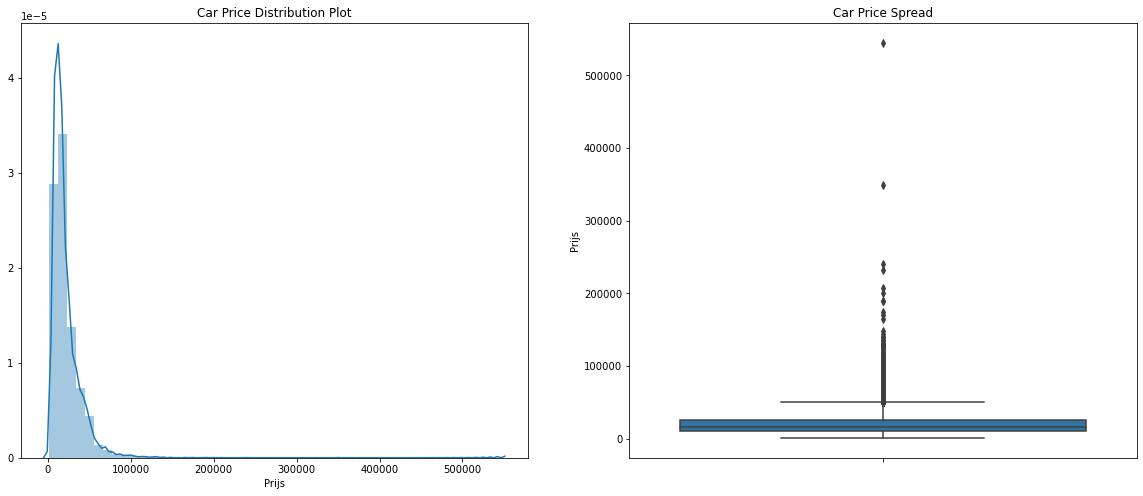

In [21]:
# Let's first see how our target column looks like
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(df.Prijs)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=df.Prijs)

plt.show()

The price of most cars seems to be lower than 100.000 euros. Let's make another plot including only the cars with a price lower than 100.000 euros.

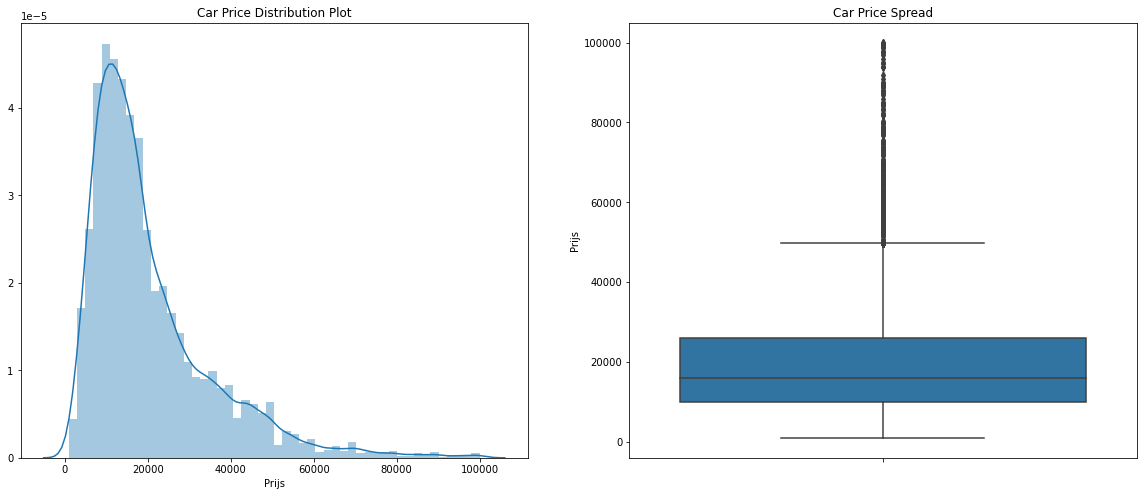

In [22]:
# Let's first see how our target column looks like
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(df.Prijs[df.Prijs < 100000])

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=df.Prijs[df.Prijs < 100000])

plt.show()

And just out of curiousity, let's look at the cars with a price above 100.000.

In [23]:
df[df.Prijs > 100000].sort_values('Prijs', ascending=False)

,Merk,Merk en model,Kilometerstand,Bouwjaar,Prijs,Wegenbelasting,Brandstof,Transmissie,Vermogen,Carrosserievorm,...,Eerste kleur,Aantal cilinders,Cilinderinhoud,Zuinigheidslabel,Catalogusprijs,WAM verzekerd,Aantal deuren,Lengte,Breedte,Type
7201,FERRARI,Ferrari 599,24800.0,08/2011,545000.0,"84,67",Benzine,Automaat,665.0,Coupé,...,GRIJS,12.0,5999.0,G,441500,Ja,2.0,471.0,0.0,F 141 ABL
137,MERCEDES-BENZ,Mercedes-Benz S-Klasse,39.0,08/2019,349800.0,"133,67",Benzine,Automaat,630.0,Cabriolet,...,BLAUW,12.0,5980.0,G,431929,Ja,2.0,0.0,0.0,221
4592,LAMBORGHINI,Lamborghini Huracán,44077.0,06/2017,239950.0,"84,67",Benzine,Automaat,610.0,Cabriolet,...,ORANJE,10.0,5204.0,NaN,328343,Ja,2.0,NaN,NaN,724
2074,MERCEDES-BENZ,Mercedes-Benz G-Klasse,28700.0,02/2019,231950.0,"158,-",Benzine,Automaat,585.0,SUV,...,ZWART,8.0,3982.0,NaN,271305,Ja,5.0,0.0,0.0,463A
7582,ROLLS ROYCE,Rolls-Royce Silver Shadow,41815.0,2015,207000.0,"141,67",Benzine,Automaat,640.0,Coupé,...,ZWART,12.0,6592.0,G,426770,Ja,2.0,527.0,0.0,GHOST FAMILY
801,MERCEDES-AMG,Mercedes-Benz AMG GT,502.0,09/2020,199900.0,"84,67",Benzine,Automaat,523.0,Coupé,...,ZWART,8.0,3982.0,NaN,236667,Ja,3.0,459.0,201.0,197
8562,MERCEDES-AMG,Mercedes-Benz SLS AMG,38950.0,07/2010,189880.0,NaN,Benzine,Automaat,571.0,Coupé,...,ROOD,8.0,6208.0,G,254619,Ja,2.0,464.0,0.0,197
5543,AUDI,Audi RS 6,2168.0,04/2020,188900.0,"117,33",Benzine,Automaat,600.0,Stationwagen,...,GRIJS,8.0,3996.0,NaN,251319,Ja,4.0,0.0,195.0,F2
5630,BMW,BMW 4 Serie Coupé,4422.0,04/2017,174950.0,"76,33",Benzine,Automaat,500.0,Coupé,...,WIT,6.0,2979.0,G,189387,Ja,2.0,469.0,0.0,M3 GTS
5298,PORSCHE,Porsche 911,29998.0,06/2019,169950.0,NaN,Benzine,Automaat,450.0,Cabriolet,...,BLAUW,6.0,2981.0,NaN,233165,Ja,2.0,NaN,185.0,992


How surprising, a Ferrari and a Lamborghini in the top 3. The prices of these cars seem to match the models of the cars, but I would like to remove them, because I consider them as outliers. I choose to remove these outliers as these cars are not within a normal budget and thus outside of the scope of the model.

In [24]:
df = df[df.Prijs < 100000]

#### Let's see if the data is normally distributed, as models love normally dsitribituted data. For linear regression for example we assume that the residuals are normally distributed. We will check this using a Q-Q plot and by looking at the Skewness and Kurtosis.

Skewness: 1.768688
Kurtosis: 3.941378


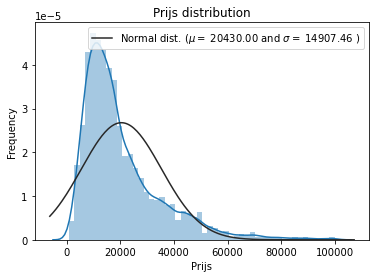

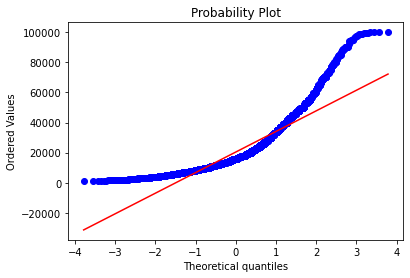

In [25]:
# Let's see if the data is normally distributed, as models love normally distributed data

#skewness and kurtosis
print("Skewness: %f" % df.Prijs.skew())
print("Kurtosis: %f" % df.Prijs.kurt())

#Let's plot
sns.distplot(df.Prijs , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df.Prijs)

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Prijs distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df.Prijs, plot=plt)
plt.show()

The target variable is right skewed. As linear models love normally distributed data we need to transform the variable to make it more normally distributed. The Probability plot shows us that the residuals are not normally distributed.

Skewness: -0.088430
Kurtosis: -0.010747


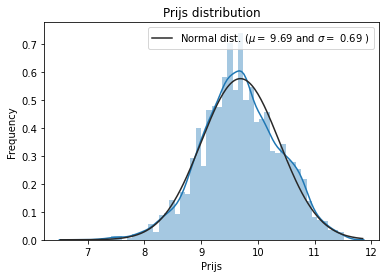

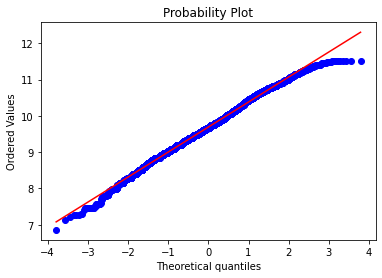

In [26]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["Prijs"] = np.log1p(df["Prijs"])

#skewness and kurtosis
print("Skewness: %f" % df.Prijs.skew())
print("Kurtosis: %f" % df.Prijs.kurt())

#Let's plot
sns.distplot(df.Prijs , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df.Prijs)

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Prijs distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df.Prijs, plot=plt)
plt.show()

Looking much better!
(Note: We should not forget to transform the variable back after making our predictions, as an average price of 10 euros sounds a bit like too much of a bargain)

#### Now we will explore the features

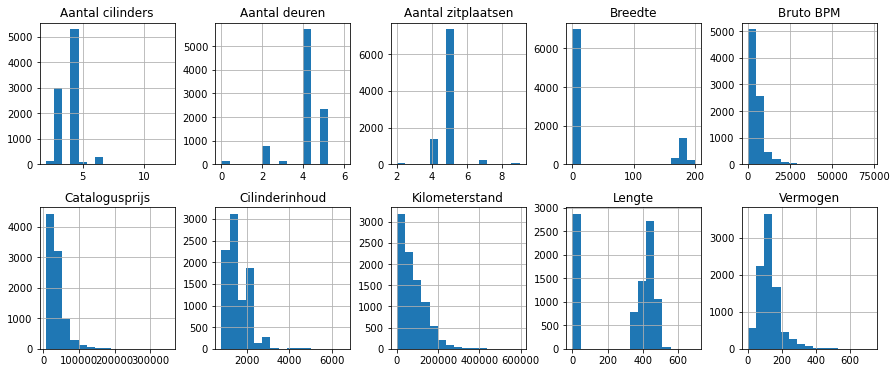

In [27]:
#Let's start with the numerical features

num_cols = df.select_dtypes(include = np.number).drop('Prijs', axis=1).columns
num_cols

df[num_cols].hist(bins=15, figsize=(15, 6), layout=(2, 5));

Great, this gives us an idea of how our numerical values look. ALlthough I do note some vehicles with lengte, breedte and aantal deuren 0 which we should fix later. 

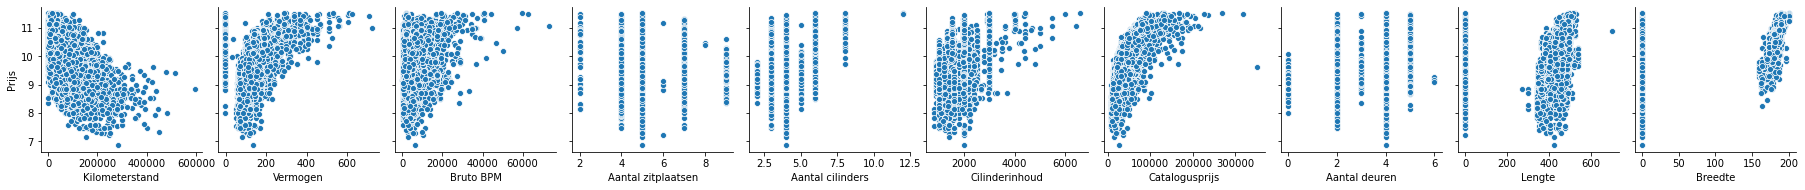

In [28]:
# And now scatterplots relating to 'Prijs'

sns.pairplot(df, y_vars="Prijs", x_vars=num_cols, height=2.5)

plt.show()

It seems that there are clear relationships between 'Kilometerstand', 'Vermogen', 'Bruto BPM', 'Cilinderinhoud', and 'Catalogusprijs' and the target variable 'Prijs. We will definitely have to include these in our model.

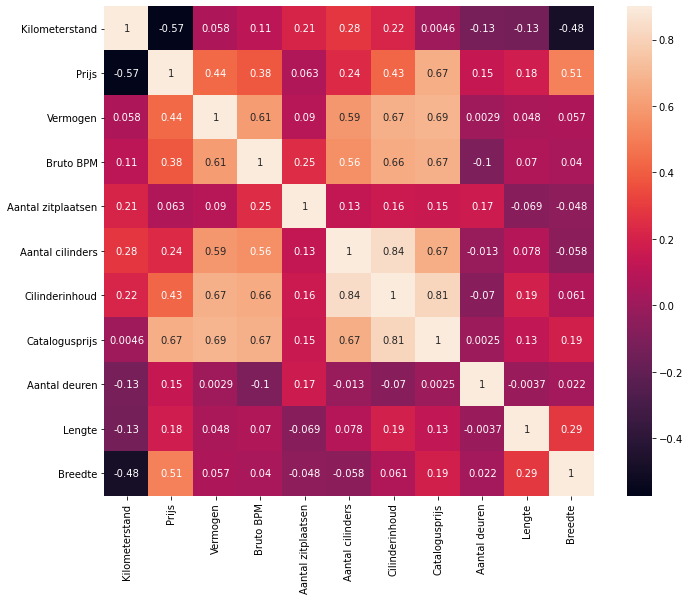

In [29]:
# We could also show this in a correlation matric

corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)

Here we see that, 'Kilometerstand, 'Vermogen', 'Bruto BPM', 'Cilinderinhoud', 'Catalogusprijs' and 'Breedte' all have an absolute Pearson Correlation coefficient of more than 0.38

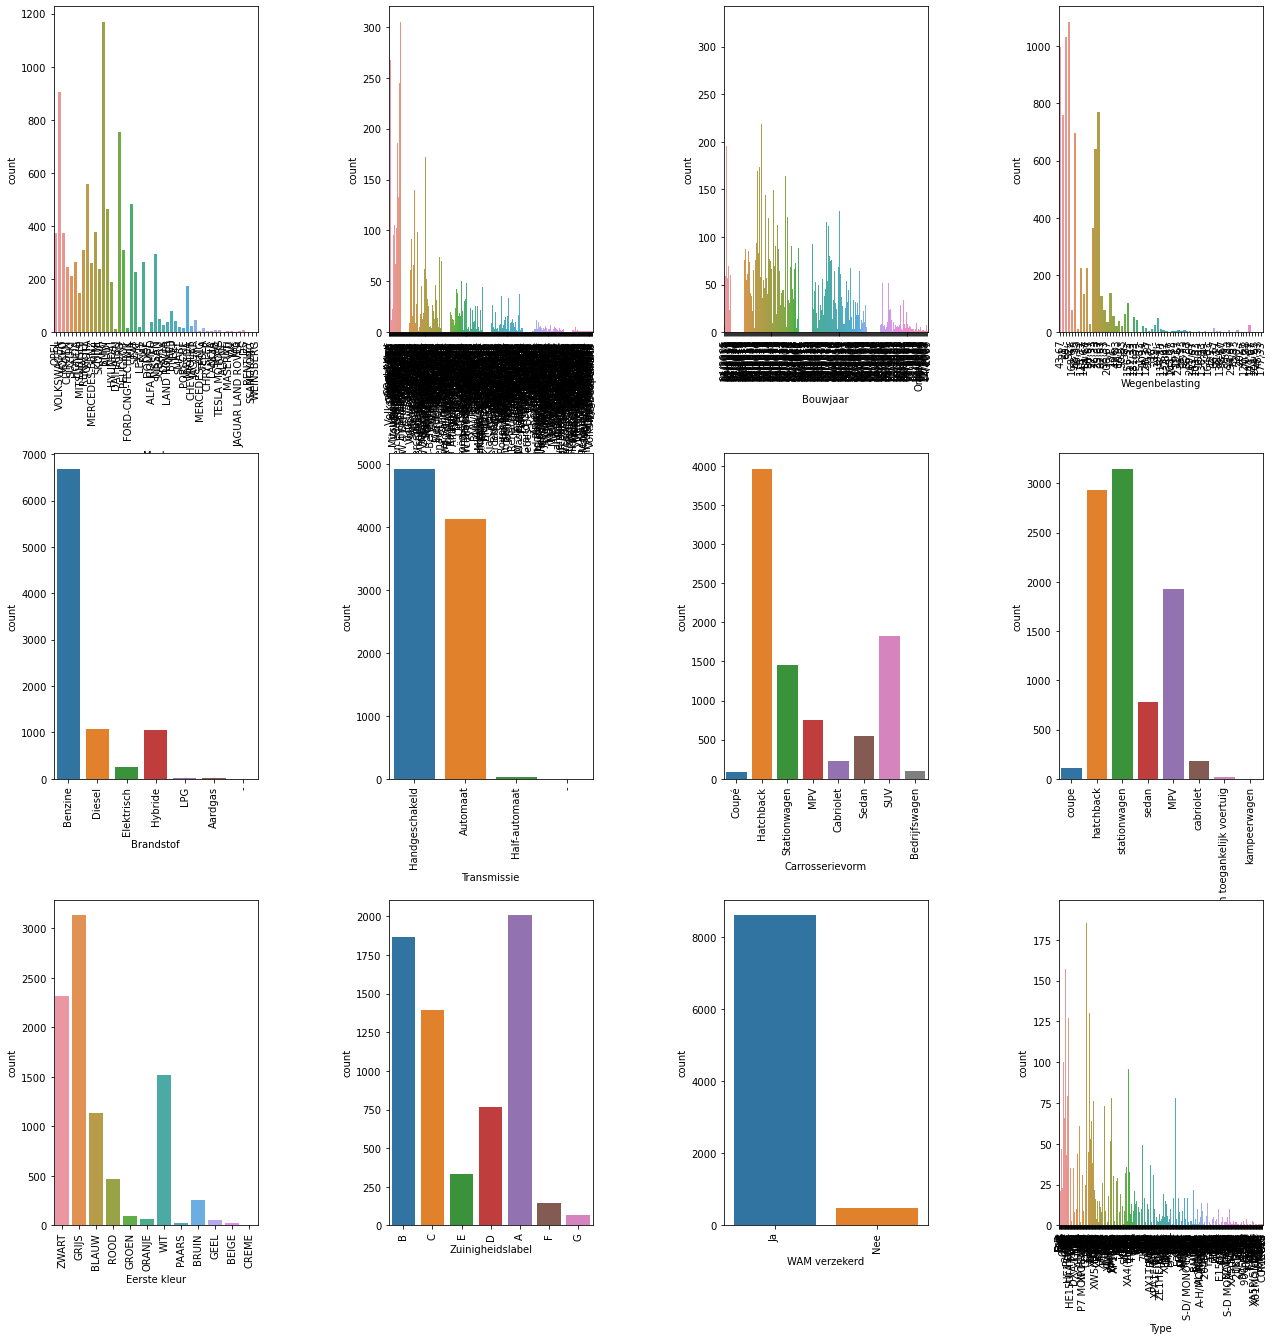

In [30]:
#Let's look at our categorical features

cat_cols = df.select_dtypes(include = ['object']).columns

fig, ax = plt.subplots(3, 4, figsize=(20, 20))
fig.tight_layout(pad=10.0)
for c, subplot in zip(cat_cols, ax.flatten()):
    sns.countplot(df[c], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

It seems only columns 5 to 11 make any sense for these kind of plots. The first two are brand and model, which of course are too much different values too much to give a nice plot. The third and fourth columns are supposed to be numerical columns and we will fix this in our data cleaning. It seems 'Inrichting' and 'Carrosserievorm' contain similar information, so we can keep one. In a moment I will check if there's any relationship between columns 5 to 11 and our target variable 'Prijs'. But first I am curious which car brand is sold the most.

In [31]:
df['Merk'].value_counts()

BMW                  1169
VOLKSWAGEN            904
FORD                  754
TOYOTA                558
KIA                   482
AUDI                  463
MINI                  378
OPEL                  375
VOLVO                 372
PEUGEOT               310
RENAULT               308
NISSAN                296
FIAT                  266
HONDA                 264
MERCEDES-BENZ         259
CITROEN               247
SKODA                 237
SEAT                  225
SUZUKI                213
HYUNDAI               187
MAZDA                 173
MITSUBISHI            146
BMW I                  81
SUBARU                 49
JAGUAR                 44
JEEP                   43
ALFA ROMEO             39
LAND ROVER             39
DACIA                  28
CHEVROLET              23
SMART                  21
LEXUS                  18
PORSCHE                17
FORD-CNG-TECHNIK       16
TESLA                  14
DAIHATSU               13
TESLA MOTORS            9
SAAB                    8
DS          

Looks like the brands in the top are what we suspected. I don't see too many used Teslas in here, which I suppose has nothing to do with low addition costs when business leasing an electrical vehicle. In the feature engineering stage we could perhaps only keep the brands with > 100 cars as their brand and bundle the other together, which will cause our dataset to not blow up too much after one hot encoding.

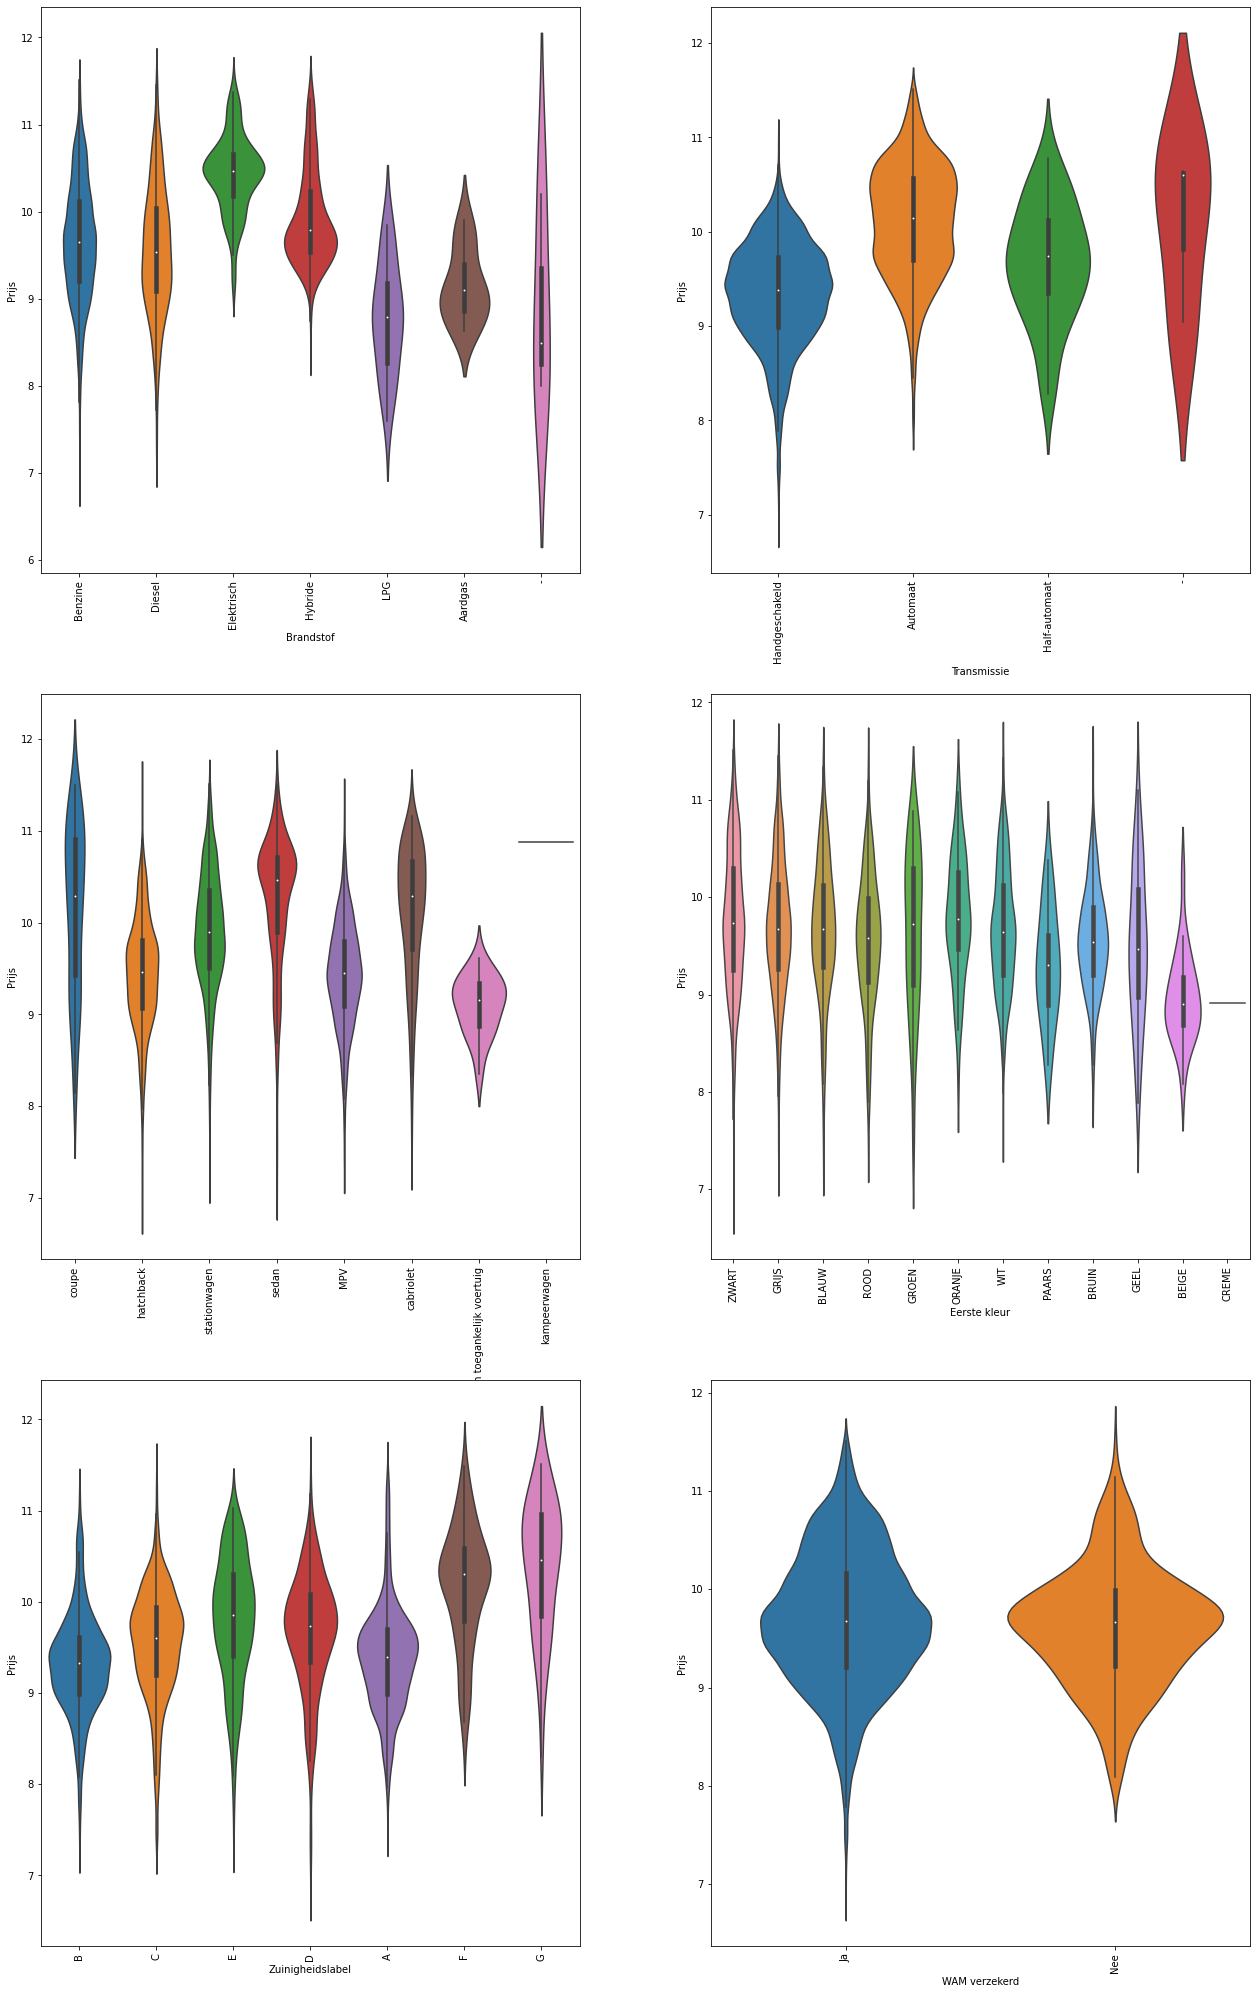

In [32]:
# Now we are interested in the relationship between the aforementioned categorical features
cat_cols_reduced = cat_cols[4:11].drop('Carrosserievorm')

fig, ax = plt.subplots(3, 2, figsize=(20, 30))
fig.tight_layout(pad=10.0)
for c, subplot in zip(cat_cols_reduced, ax.flatten()):
    sns.violinplot(data=df, x=c, y='Prijs', ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

It seems 'Eerste kleur' does not really influence the price. This is what I expected beforehand, but it is always better to confirm your hunch with actual data. 'Wam verzekerd' does not really show any correlation with our target variable as well.

# 4. Data cleaning and feature engineering

We have now arrived in a very important step in the pipeline of building a machine learning model: the data cleaning and feature engineering.

In [34]:
df.columns

Index(['Merk', 'Merk en model', 'Kilometerstand', 'Bouwjaar', 'Prijs',
       'Wegenbelasting', 'Brandstof', 'Transmissie', 'Vermogen',
       'Carrosserievorm', 'Bruto BPM', 'Inrichting', 'Aantal zitplaatsen',
       'Eerste kleur', 'Aantal cilinders', 'Cilinderinhoud',
       'Zuinigheidslabel', 'Catalogusprijs', 'WAM verzekerd', 'Aantal deuren',
       'Lengte', 'Breedte', 'Type'],
      dtype='object')

In [35]:
# After my EDA I have decided to drop the following columns:

cols_dropped = ['WAM verzekerd', 'Eerste kleur', 'Carrosserievorm', 'Merk en model', 'Type']

df.drop(cols_dropped, axis=1, inplace=True)

#### As I rememberd from earlier, I have to clean Wegenbelasting and  Bouwjaar, let's start with that.

In [36]:
# This is the current format of Wegenbelasting
print(df['Wegenbelasting'])

0        43,67
1         21,-
2        43,67
3         60,-
4         52,-
         ...  
9135     43,67
9136    118,33
9137       NaN
9138     43,67
9139      52,-
Name: Wegenbelasting, Length: 9088, dtype: object


In [37]:
# Using regex to capture the amount in euros
df['Wegenbelasting'] =  (df['Wegenbelasting'].str.extract(r'(\d+)').astype(float) + 
                          (1/100) *  df['Wegenbelasting'].str.extract(r'\d+,(\d+)').astype(float).fillna(0)) 

# Looking great
print(df['Wegenbelasting'])

0        43.67
1        21.00
2        43.67
3        60.00
4        52.00
         ...  
9135     43.67
9136    118.33
9137       NaN
9138     43.67
9139     52.00
Name: Wegenbelasting, Length: 9088, dtype: float64


In [38]:
# Current format of Bouwjaar
print(df['Bouwjaar'])

0       04/2005
1       11/2018
2       01/2017
3       06/2015
4       09/2018
         ...   
9135    03/2020
9136    08/2015
9137    03/2019
9138    07/2017
9139    05/2011
Name: Bouwjaar, Length: 9088, dtype: object


In [39]:
#Checking if all dates are the same format
print(df['Bouwjaar'][df['Bouwjaar'].apply(lambda x: len(x)) != 7])
print(len(df['Bouwjaar'][df['Bouwjaar'].apply(lambda x: len(x)) != 7]))

698         2016
884         2014
986         2014
988         2008
1015        2013
1087        2013
1377        2021
1386        2021
2145        2020
2403        2019
2433        2018
2580        2015
2798        2017
3641        2021
3738    Onbekend
3997        2020
4113        2014
4454        2019
4854        2014
4975        2016
5431        2014
5876        2011
6521        2018
6636        2017
6667        2015
6701        2017
6789    Onbekend
7323        2020
7356        2013
7523        2009
7525        2016
7579        2015
7981        2018
8076        2014
8116        2020
8445        2016
8577        2014
8703        2019
8949        2011
9041        2020
Name: Bouwjaar, dtype: object
40


38 rows have only a year given and 2 rows are 'Onbekend'. I will drop the rows with 'Onbekend'

In [40]:
# Dropping 'Onbekend'
df = df[df['Bouwjaar'] != 'Onbekend']

In [41]:
# Creating two new columns for month and year using Regex and dropping old column
df['Bouwjaar (month)'] = df['Bouwjaar'].str.extract(r'(\d+)/')
df['Bouwjaar (year)'] = df['Bouwjaar'].str.extract(r'(\d{4})')
df.drop('Bouwjaar', axis=1, inplace=True)

#### A lot of machine learning models don't like missing data, so let's check for missing data. We also have to keep in mind that we have found 0 for things like number of doors, I believe this should also be handled as missing data.

In [42]:
#Filling in np.nan for 0 and -1 (which we used for our null colums earlier) in the following columns
cols = ['Aantal zitplaatsen', 'Aantal cilinders', 'Aantal deuren', 'Lengte', 'Breedte']

for c in cols:
    df[c] = df[c].apply(lambda x: np.nan if (x == 0 or x == -1) else x)

# Missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Ratio'])
missing_data.head(20)

,Total,Ratio
Breedte,7146,0.786485
Lengte,3050,0.335681
Zuinigheidslabel,2510,0.276249
Wegenbelasting,1003,0.110390
Bruto BPM,663,0.072969
Cilinderinhoud,246,0.027075
Aantal cilinders,246,0.027075
Aantal deuren,138,0.015188
Bouwjaar (month),38,0.004182
Aantal zitplaatsen,1,0.000110


There are 3 main ways in handling with missing data (4 if you include just leave them):
 <ul>
 <li>Delete a column containing (too much) missing data</li>
 <li>Delete rows containing missing data</li>
 <li>Impute a value for the missing values</li>
 </ul>

There are 3 columns with a significant amount of missing data: Breedte, Lengte and Zuinigheidslabel. As I recall from my EDA, Breedte actually had a pretty big correlation with Prijs, so we would prefer to keep this one. I also chose to keep and impute all the other columns, as this is a good practice. 

#### Time to impute the missing values

C:\Users\Aswin\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Aswin\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Aswin\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.wa

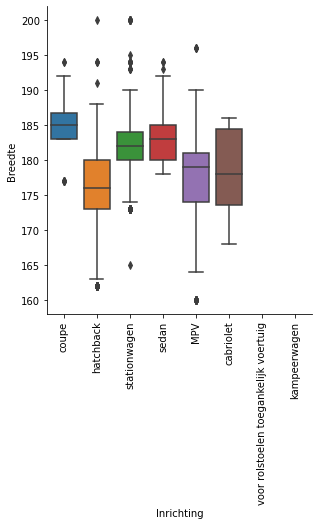

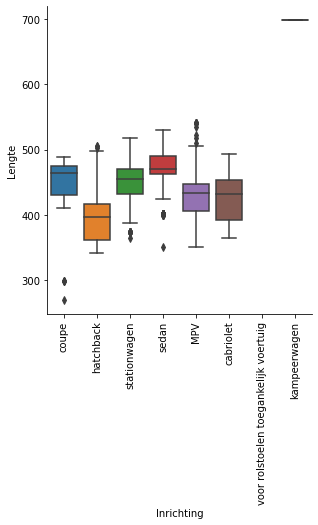

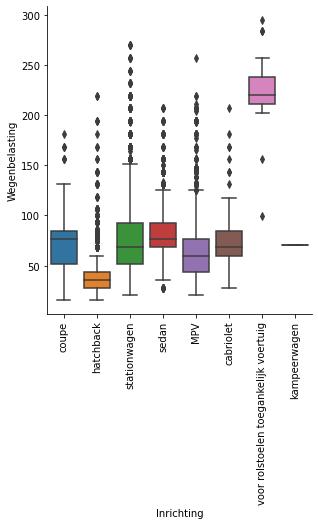

In [43]:
# Breedte and Lengte of a car are probably related to the 'Inrichting'. Same for wegenbelasting.
# Let's explore Breedte, Lengte and Wegenbelasting vs Inrichting
cols = ["Breedte", "Lengte", "Wegenbelasting"]
for c in cols:
    g = sns.factorplot(y=c,x="Inrichting", data=df, kind="box")
    g.set_xticklabels(rotation=90)


##### We see some correlation, so let's group them together with Inrichting

In [44]:
# We will find the median value of these columns grouped by 'Inrichting' and use this for imputing.
df["Breedte"] = df.groupby("Inrichting")["Breedte"].transform(lambda x: x.fillna(x.median()))
df["Lengte"] = df.groupby("Inrichting")["Lengte"].transform(lambda x: x.fillna(x.median()))

# For Zuinigheidslabel I will fill this with unknown, which could be another good predictor
df['Zuinigheidslabel'] = df['Zuinigheidslabel'].fillna('Unknown')

# For month, I will input 01, as this is the most occuring month. 
# I could have also chosen to input 06/07 as this is more in the middle, 
# but then the cars with year 2021 would run into a problem, as it is difficult to manufacture cars in the future
df['Bouwjaar (month)'] = df['Bouwjaar (month)'].fillna('01')

#For the other columns I will impute the median, as a relative low number of rows is empty for these columns
cols = ['Wegenbelasting', 'Bruto BPM', 'Cilinderinhoud', 'Aantal cilinders', 'Aantal deuren',
        'Aantal zitplaatsen', 'Breedte', 'Lengte']
for c in cols:
    df[c] = df[c].fillna(df[c].median())

In [45]:
# Let's check if we have any missing values left
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Ratio'])
missing_data.head(20)

,Total,Ratio
Bouwjaar (year),0,0.0
Inrichting,0,0.0
Kilometerstand,0,0.0
Prijs,0,0.0
Wegenbelasting,0,0.0
Brandstof,0,0.0
Transmissie,0,0.0
Vermogen,0,0.0
Bruto BPM,0,0.0
Aantal zitplaatsen,0,0.0


#### Succes!

#### We did some data cleaning and imputed missing values. Now it's time to create new features: feature engineering.

In [46]:
# There are a lot of different values in 'Merk', let's bundle together all those with less than 100 occurances
cols = df['Merk'].value_counts()[df['Merk'].value_counts() < 100].index
df['Merk'] = df['Merk'].apply(lambda x: 'Other' if (x in cols) else x)

# Combine the month and year columns into one datetime column
# Calculate the age of the car in months and drop the year and month column

df['Date'] = pd.to_datetime(df['Bouwjaar (month)']+df['Bouwjaar (year)'], format = '%m%Y')
df['Today'] = date.today()
df['Days_old'] = (pd.to_datetime(df['Today']) - df['Date']) / np.timedelta64(1, 'D')
df.drop(['Date','Today','Bouwjaar (month)','Bouwjaar (year)'], axis=1, inplace=True)



I believe there is a combination between 'Catalogusprijs' and 'Days_old' / 'Kilometerstand' which would be a good predictor.
A linear regression model for example, can not create these features itself, so I will create them.
In a sense this is my futile attempt to create a model from my head, a so called head learning model if you will.
I believe there will be a relationship similar to 'Prijs' = 'Catalogusprijs * x^('Kilometerstand') * x^('Days_old').
A quick search shows me (first link I clicked on) that the average depreciation of a car is 15% per year. This is of course not a perfect model, as relative more depreciation happens in the earlier years. The number I found online already takes the driven km into account, so I will only create one feature which only takes in account the number of days and one which takes both into account where I give my best guess. I make the assumption that years and number of km both contribute for 7.5% and I will use the average driving distance per year in the Netherlands (again found on the first site) which is 13.000 km per year.

In [47]:
# I will create multiple new features. I will create two for 'Days_old' and 'Days_old' and 'Kilometerstand' combined
df['Catalogus^days_old'] = df['Catalogusprijs'] * (0.85 ** (df['Days_old'] / 365))
df['Catalogus^days_old^kilometer'] = df['Catalogusprijs'] * (0.925 ** (df['Days_old'] / 365)) * (0.925 ** (df['Kilometerstand'] / 13000))

#### Now we normalize the data, which is important for many algorithms to learn faster. I choose to normalize the data instead of standardize the data, as my data does not have to be normally distributed.

In [48]:
# Let's first check for outliers in "Catalogusprijs, before we transform the data"
print(len(df[df['Catalogusprijs'] > 100000]))

210


I choose to remove these 210 rows, as I am focused on the lower prices and having only one high number would already change the scale drastically.

In [49]:
# Removing outliers
df = df[df['Catalogusprijs'] < 100000]

# Let's create a df for our bargain use case right now
df_bargain = df

In [50]:
# Now let's transform the numerical columns to all be between and including 0 and 1. We exlucde the target variable
num_cols = df.select_dtypes(include = np.number).drop('Prijs', axis=1).columns

scaler = MinMaxScaler()
transformed_df = scaler.fit_transform(df[num_cols])
transformed_df = pd.DataFrame(transformed_df, columns = num_cols)
old_df = df.drop(num_cols, axis=1)


# Add the transformed df back to the rest of the df
df = pd.DataFrame(np.hstack([old_df,transformed_df]), columns = old_df.columns.append(transformed_df.columns))
df[num_cols] = df[num_cols].astype(float)
df.Prijs = df.Prijs.astype(float)

#### Most machine learning algorithms won't work with text input. Let's one-hot-encode the categorical features

In [51]:
df = pd.get_dummies(df)

print (f"The final dataset which we will use for our model has {df.shape[0]} rows and {df.shape[1]} columns")

The final dataset which we will use for our model has 8876 rows and 65 columns


# 4. Modelling

We obtained a dataset, performed EDA, cleaned the data and performed feature engineering. Now it is time to see how well we can model 'Prijs' and if we can really make a good model which will help us to find a great bargain. Let's find out!

#### Before we start the modelling we first want to split our dataset into a train and test set. We also want to keep apart a part of the data for our goal to find cars which are a bargain. We keep 70% for train, 20% for test and 10% for bargain

In [52]:
# First create a train and temp set, then split the temp into a test and bargain set
train, temp = train_test_split(df, test_size = 0.3, random_state=42)
test, bargain = train_test_split(temp, test_size=(1/3), random_state=42)
test['Prijs'] = test['Prijs']

<ipython-input-52-7b88d02afe88>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prijs'] = test['Prijs']


In [53]:
# Define the train and test sets.
x_train = train.drop('Prijs', axis=1)
y_train = train['Prijs']
x_test = test.drop('Prijs', axis=1)
y_test = test['Prijs']

#### I like to first create a baseline model, to place my results in context. I will use a simple Linear regression model and an often very accurate model the XGBoost model. I will evaluate them using the MAE and MAPE.

In [56]:
%%time
# Write a function to calculate the MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Write a function to create the model, train it, fit it and see how it performs
def find_performance(model):
    model.fit(x_train,y_train)
    preds_train = model.predict(x_train)
    preds = model.predict(x_test)
    preds_t = np.expm1(preds)
    test = y_test
    test_t = np.expm1(test)
    print(f'The model has an MAE of: {mean_absolute_error(y_train,preds_train)} on the train set itself, without transforming the price back')
    print(f'The model has an MAE of: {mean_absolute_error(test,preds)} on the test set, without transforming the price back')
    print(f'The model has an MAPE of: {mean_absolute_percentage_error(test,preds)}% on the test set, without transforming the price back')
    print(f'The model has an MAE of: {mean_absolute_error(test_t,preds_t)} on the test set, after transforming the price back')
    print(f'The model has an MAPE of: {mean_absolute_percentage_error(test_t,preds_t)}% on the test set, after transforming the price back')
    return model

lr = find_performance(LinearRegression())

The model has an MAE of: 0.12236853807713123 on the train set itself, without transforming the price back
The model has an MAE of: 0.12762147427069967 on the test set, without transforming the price back
The model has an MAPE of: 1.350854371775922% on the test set, without transforming the price back
The model has an MAE of: 2307.823002930878 on the test set, after transforming the price back
The model has an MAPE of: 13.232002930545692% on the test set, after transforming the price back
Wall time: 63.8 ms


A MAE of 2308 euros and a MAPE of 13.2%. Not bad for our first model. And the MAE for the train and the test set are really close, which means that our model generalizes very well and doesn't overfit.

In [57]:
# Let's compare it with a XGBoost model
xgb = find_performance(xgboost.XGBRegressor())

The model has an MAE of: 0.042007564857123016 on the train set itself, without transforming the price back
The model has an MAE of: 0.08641187489674979 on the test set, without transforming the price back
The model has an MAPE of: 0.9177566632444194% on the test set, without transforming the price back
The model has an MAE of: 1495.9140260508364 on the test set, after transforming the price back
The model has an MAPE of: 8.76252043374123% on the test set, after transforming the price back


Our XGBoost model has an ever better prediction! I do however notice that our XGBoost function seems to overfit as the MAE on the training data is much lower than on the test data. Since our MAE on the test data is still better I prefer XGBoost in this case, but if we want to have this model generalize better we have to combat the overfitting. The docs of XGBoost tell me that the parameters max_depth, min_child_weight and gamma could be tuned to combat overfitting (https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html).

####  A fun thing about for example the XGBoost model is that it has the ability to show the feature importances. Let's take a peek.

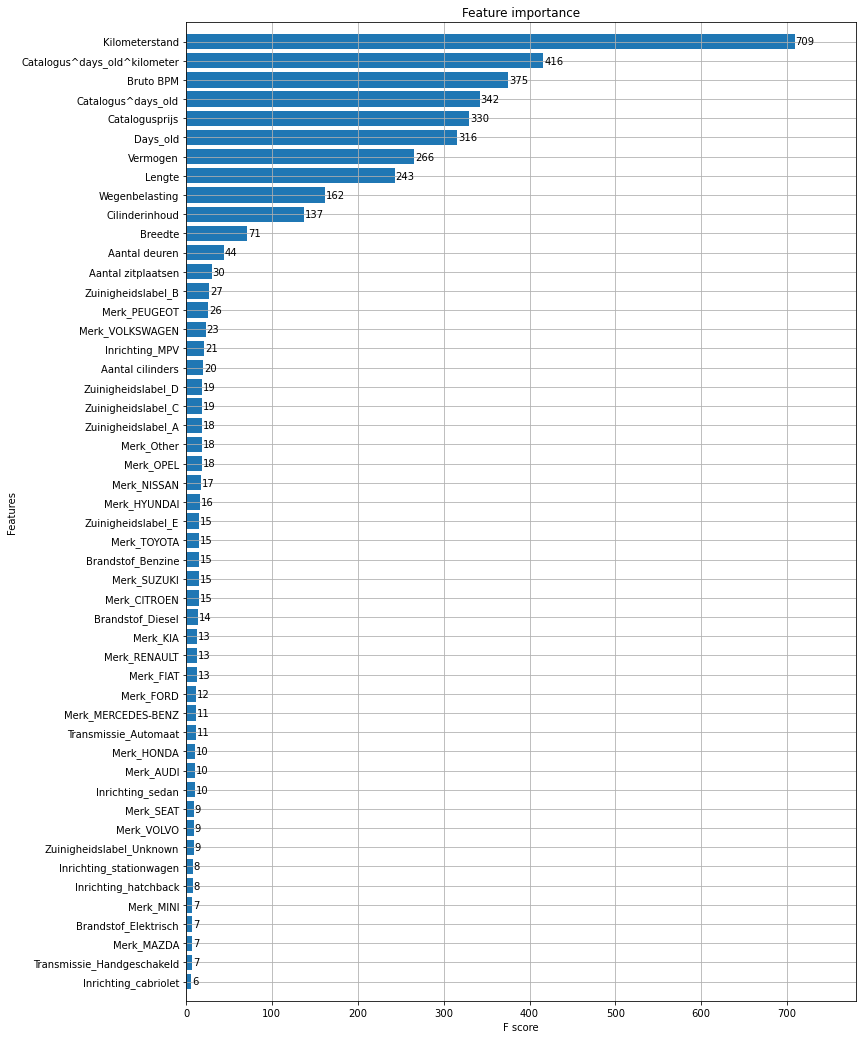

In [58]:
# Show the feature importances
fig, ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

That looks cool! Apperently 'Kilometerstand' is the most important feature in predicting 'Prijs' (according to this model). Three of our created features are in the top 6, which tells me that the feature engineering stage really added something to the result.

#### Let's also try out deep learning in the form of a MLP, just because we can. Deep learning models love lots of data, so I don't expect this to perform better

In [59]:
# Separate features and targets
x = x_train.to_numpy()
y = y_train.to_numpy()

# Set the input shape
input_shape = (64,)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(16, input_shape=input_shape, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Configure the model and start training
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.fit(x, y, epochs=100, batch_size=1, verbose=1, validation_split=0.2)

Feature shape: (64,)
Epoch 1/100
4970/4970 [==============================] - 3s 495us/step - loss: 1.4510 - mean_absolute_error: 1.4510 - val_loss: 0.2025 - val_mean_absolute_error: 0.2025
Epoch 2/100
4970/4970 [==============================] - 2s 446us/step - loss: 0.1926 - mean_absolute_error: 0.1926 - val_loss: 0.1928 - val_mean_absolute_error: 0.1928
Epoch 3/100
4970/4970 [==============================] - 2s 442us/step - loss: 0.1656 - mean_absolute_error: 0.1656 - val_loss: 0.1915 - val_mean_absolute_error: 0.1915
Epoch 4/100
4970/4970 [==============================] - 2s 444us/step - loss: 0.1578 - mean_absolute_error: 0.1578 - val_loss: 0.1345 - val_mean_absolute_error: 0.1345
Epoch 5/100
4970/4970 [==============================] - 2s 453us/step - loss: 0.1522 - mean_absolute_error: 0.1522 - val_loss: 0.2379 - val_mean_absolute_error: 0.2379
Epoch 6/100
4970/4970 [==============================] - 2s 455us/step - loss: 0.1500 - mean_absolute_error: 0.1500 - val_loss: 0.1378

4970/4970 [==============================] - 2s 461us/step - loss: 0.0959 - mean_absolute_error: 0.0959 - val_loss: 0.1020 - val_mean_absolute_error: 0.1020
Epoch 98/100
4970/4970 [==============================] - 2s 468us/step - loss: 0.0952 - mean_absolute_error: 0.0952 - val_loss: 0.0973 - val_mean_absolute_error: 0.0973
Epoch 99/100
4970/4970 [==============================] - 2s 454us/step - loss: 0.0957 - mean_absolute_error: 0.0957 - val_loss: 0.1157 - val_mean_absolute_error: 0.1157
Epoch 100/100
4970/4970 [==============================] - 2s 463us/step - loss: 0.0970 - mean_absolute_error: 0.0970 - val_loss: 0.1055 - val_mean_absolute_error: 0.1055


In [60]:
preds = model.predict(x_test)
preds_t = np.expm1(preds)
test = y_test
test_t = np.expm1(test)
print(f'The model has an MAE of: {mean_absolute_error(test,preds)} without transforming the price back')
print(f'The model has an MAE of: {mean_absolute_error(test_t,preds_t)} after transforming the price back')

The model has an MAE of: 0.10266460425607218 without transforming the price back
The model has an MAE of: 1896.9451481349033 after transforming the price back


As we expected the MLP did not reach a better MAE then the XGBoost model. Of course lots of parameter tuning could make the MLP perform better than this but I will not do that now, as I believe a deep learning model won't perform better anyways.

#### Now we will try and train a model which will beat our baseline model with a MAE of around 1500 euros. We will first try out a bunch of different algorithms and we will choose some of the models to further improve using hyperparameter tuning. I have chosen not to use d

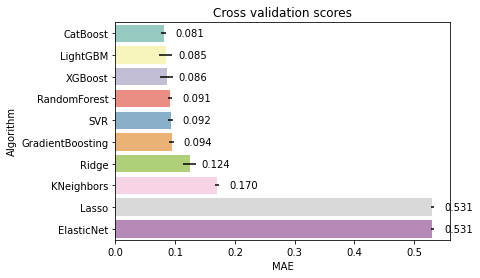

In [61]:
# We choose a bunch of popular regression algorithm and append them to a list
regressors = []
regressors.append(Ridge())
regressors.append(Lasso())
regressors.append(ElasticNet())
regressors.append(RandomForestRegressor())
regressors.append(GradientBoostingRegressor())
regressors.append(SVR())
regressors.append(KNeighborsRegressor())
regressors.append(catboost.CatBoostRegressor(silent=True))
regressors.append(lightgbm.LGBMRegressor())
regressors.append(xgboost.XGBRegressor())

# We use KFold cross validation to compare these models
cv_results = []
for r in regressors:
    cv_results.append(cross_val_score(r, x_train, y = y_train, scoring = "neg_mean_absolute_error", cv = 10, n_jobs=-1))

# Append the means and the standard deviation to lists
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(abs(cv_result.mean()))
    cv_std.append(cv_result.std())

# Create a df with the results
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValstd": cv_std,"Algorithm":["Ridge","Lasso",
"ElasticNet","RandomForest","GradientBoosting","SVR","KNeighbors","CatBoost","LightGBM","XGBoost"]})
cv_res.sort_values('CrossValMeans', inplace=True)

# Plot the results
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
for p in g.patches:
    width = p.get_width()    # get bar length
    g.text(width + 0.02,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.3f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
g.set_xlabel("MAE")
g = g.set_title("Cross validation scores")


It appears that the best performing model without any parameter tuning is CatBoost. Let's see if we can improve the performance of CatBoost using some hyperparameter tuning. I found these parameters in the documentation of CatBoost (https://catboost.ai/docs/concepts/parameter-tuning.html), where they say values in the range 6-10 are recommended for 'depth'. I could of course choose much more hyperparameters to choose, but for now I leave it with these.

In [63]:
# We perform hyperparameter tuning on the test dataset using RandomizedSearchCV
# I chose to use RandomizedGridsearch to reduce compute time and as this will normally give a result equal or close to
# the best possible result
cat = catboost.CatBoostRegressor(silent=True)

cat_param_grid = {'depth'         : [6,8,10],
                  'iterations'    : [2500]}

gscat = GridSearchCV(cat ,param_grid = cat_param_grid, cv=5, scoring="neg_mean_absolute_error", 
                           n_jobs= 4, verbose = 1)

gscat.fit(x_train,y_train)

best_model = gscat.best_estimator_
print(f'The best performing hyperparameters are: {gscat.best_params_}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  4.9min finished


The best performing hyperparameters are: {'depth': 8, 'iterations': 2500}


In [64]:
find_performance(best_model)

The model has an MAE of: 0.041442105844915214 on the train set itself, without transforming the price back
The model has an MAE of: 0.07947543308582972 on the test set, without transforming the price back
The model has an MAPE of: 0.8454063229447849% on the test set, without transforming the price back
The model has an MAE of: 1376.4626890929378 on the test set, after transforming the price back
The model has an MAPE of: 8.074422185110839% on the test set, after transforming the price back


Great, we obtained an MAE of 1376 euros and an MAPE of 8.1 %. The model performs well enough for me at the moment and since right now I am making the model for myself, I will leave it at this. I do still notice an overfitting however, which would be one of the first things I would look at if I were to improve this model. It is however important to note that the hyperparameters are chosen so that the model performs the best on the 5 folds of our K-fold Cross-Validation. Therefore we already choose the hyperparameters which best generalize to the other folds.

#### We saw that the model overfits a little. As a last check I would however like to look at the learning curves, as these give a lot of visual information about whether the model overfits.

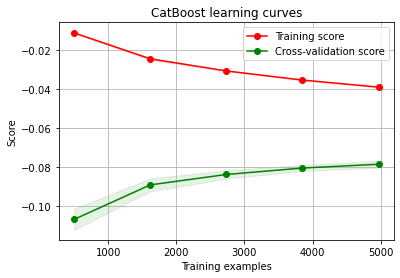

In [71]:
# We define a function which lets us plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'neg_mean_absolute_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(best_model,"CatBoost learning curves",x_train,y_train)

As we can see from the model the training score and the cross validation score are still apart by quite far, but they move closer to eachother after more training examples.

#### For the moment I am happy with the performance of the model. In a later stage I might want to come back and further improve my model. These are the things I could do to further improve my model:

I am happy with the results we obtained so far, but of course the model could always be further improved. I will give a few way to improve the accuracy of the model:
<ul>
 <li>Collect more data. Which can mean collect more rows of data and/or collect new columns (features).</li>
    <li>Make sure the model does not overfit as much and thus generalizes better on new data.</li>
 <li>Test the features which I left out at the beginning.</li>
     <li>Perform more feature engineering.</li>
 <li>Perform hyperparameter tuning on more models to see if they perform better.</li>
 <li>Take an average model of multiple models. An average model of multiple different algorithms if often more accurate.</li>
 <li>Perform feature selection by using for example. </li>

# 5. Results and conclusion

Now I want to of course see if I can find a bargain using the model we just created. I will fit the model using the train and test data, as more data means a more accurate model.

In [66]:
# Making the predictions
x = pd.concat([x_train,x_test])
y = pd.concat([y_train,y_test])
model = best_model
model.fit(x_train,y_train)
preds = np.expm1(model.predict(bargain.drop(['Prijs'], axis=1)))

In [68]:
preds_df = pd.Series(preds, name = 'Predicted prijs')


df_final = pd.concat([df_bargain.iloc[list(bargain.index)].reset_index(drop=True), preds_df.reset_index(drop=True)], axis=1)
df_final['Prijs'] = np.expm1(df_final['Prijs'])
df_final['Price percentage off'] = (1 - (df_final['Prijs'] / df_final['Predicted prijs']))*100

df_final.sort_values('Price percentage off', ascending=False)[['Merk','Kilometerstand','Catalogusprijs', 'Days_old',
                                                               'Prijs','Predicted prijs', 'Price percentage off']].head(10)

,Merk,Kilometerstand,Catalogusprijs,Days_old,Prijs,Predicted prijs,Price percentage off
680,VOLKSWAGEN,358783.0,61422,3875.0,4250.0,8382.232721,49.297518
736,CITROEN,238371.0,40155,3418.0,3945.0,7772.715451,49.245537
712,FIAT,143635.0,11503,4178.0,2490.0,3994.294921,37.661088
786,Other,123622.0,25985,4513.0,3950.0,5876.489562,32.783000
714,VOLKSWAGEN,187792.0,38580,3479.0,7900.0,11098.252514,28.817623
608,VOLKSWAGEN,63001.0,45657,769.0,19840.0,27552.904602,27.993073
497,VOLVO,96745.0,54995,1926.0,12900.0,17663.678566,26.968780
328,VOLKSWAGEN,91641.0,46967,1499.0,17900.0,24246.198247,26.173993
277,VOLKSWAGEN,33682.0,60928,557.0,30900.0,41518.288828,25.574967
190,OPEL,124823.0,25433,3326.0,6450.0,8533.429737,24.414916


As we can see there are a few bargains available. The Volkswagen and Citroen are listed for only half of what they're worth! Of course I now realize I forgot to include the link to the advertention to my dataset, but I can always go back and add it later. It's not like I want a car myself right now anyways.

#### Conclusion

I put down three goals when starting on this notebook: learn to use Beautifulsoup, combine multiple datasets into one cool new dataset and to create a machine learning model which lets me predict car prices. I managed to reach all these goals and learn a lot in the process. Not only that, I now know which cars are a great bargain and if I ever want to buy a new car I can brag about the great price to all my friends and family! On top of that this model could be used for other things like calculating which price you should ask for the car you went to sell. All in all I believe that the the project was a great success!